# Consistent hashing from first principles - Part 1

In [3]:
!pip install -q mmh3==3.0.0
!pip freeze | grep mmh3

mmh3==3.0.0


In [1]:
def allocate(url: str, server_count: int) -> int:
    ...

In [2]:
from typing import Callable


def allocate_modulo(
    url: str,
    server_count: int,
    hash_fn: Callable[[str], int],
) -> int:
    return hash_fn(url) % server_count

In [4]:
import functools
import mmh3


SEED = 0


def hash_mmh3(key: str, seed: int = SEED) -> int:
    return mmh3.hash(key, seed=seed)


assert hash_mmh3(key='x') == 1050319643

allocate_modulo_mmh3 = functools.partial(
    allocate_modulo,
    hash_fn=hash_mmh3,
)

In [5]:
urls = [
    'wikipedia.org',
    'instagram.com',
    'google.com',
    'youtube.com',
    'apple.com',
    'arxiv.org',
]

In [6]:
import pandas as pd
from typing import List


def allocate_urls(
    urls: List[str],
    server_count: int,
) -> pd.DataFrame:
    return pd.DataFrame(
        dict(
            url=url,
            hash_value=hash_mmh3(url),
            server_index=allocate_modulo_mmh3(
                url=url,
                server_count=server_count,
            ),
        )
        for url in urls
    )

In [7]:
df1 = allocate_urls(urls=urls, server_count=3)
df1

,url,hash_value,server_index
0,wikipedia.org,1279360222,1
1,instagram.com,-1059558490,2
2,google.com,-315053210,1
3,youtube.com,394031484,0
4,apple.com,-1612700317,2
5,arxiv.org,202658087,2


In [8]:
import string
import numpy as np


def random_str() -> str:
    return "".join(np.random.choice(
        # select from lowercase letters
        list(string.ascii_lowercase),
        # generate a string that's between 6 to 20
        # characters long
        size=np.random.randint(6, 20),
        replace=True,
    ))

In [9]:
# these are random and will be slightly different per run
allocate_urls(
    urls=[random_str() for _ in range(10_000)],
    server_count=3,
).server_index.value_counts(normalize=True)

2    0.3377
0    0.3326
1    0.3297
Name: server_index, dtype: float64

In [10]:
df2 = allocate_urls(urls, server_count=4)
df2

,url,hash_value,server_index
0,wikipedia.org,1279360222,2
1,instagram.com,-1059558490,2
2,google.com,-315053210,2
3,youtube.com,394031484,0
4,apple.com,-1612700317,3
5,arxiv.org,202658087,3


In [12]:
def after(
    df_before: pd.DataFrame,
    df_after: pd.DataFrame,
) -> pd.DataFrame:
    df_after = df_before.merge(
        df_after,
        on=['url', 'hash_value'],
        suffixes=['_before', '_after'],
    )
    idx_before = df_after.server_index_before
    idx_after = df_after.server_index_after
    return df_after.assign(same=idx_before == idx_after)


df_after = after(df_before=df1, df_after=df2)
df_after

,url,hash_value,server_index_before,server_index_after,same
0,wikipedia.org,1279360222,1,2,False
1,instagram.com,-1059558490,2,2,True
2,google.com,-315053210,1,2,False
3,youtube.com,394031484,0,0,True
4,apple.com,-1612700317,2,3,False
5,arxiv.org,202658087,2,3,False


In [13]:
assert df_after.same.sum() == 2

In [14]:
def same_allocation(
    servers_before: int,
    servers_after: int,
    url_count: int=100,
    repeat: int=100,
) -> float:
    urls_list = [
        [random_str() for _ in range(url_count)]
        for _ in range(repeat)
    ]
    return np.mean([
        after(
            df_before=allocate_urls(
                urls=urls,
                server_count=servers_before,
            ),
            df_after=allocate_urls(
                urls=urls,
                server_count=servers_after,
            ),
        ).same.mean()
        for urls in urls_list
    ])

In [15]:
assert np.allclose(
    same_allocation(servers_before=3, servers_after=4),
    0.25,
    atol=1e-2,
)

In [16]:
assert np.allclose(
    same_allocation(servers_before=4, servers_after=5),
    1 / 5,
    atol=1e-2,
)
assert np.allclose(
    same_allocation(servers_before=5, servers_after=6),
    1 / 6,
    atol=1e-2,
)

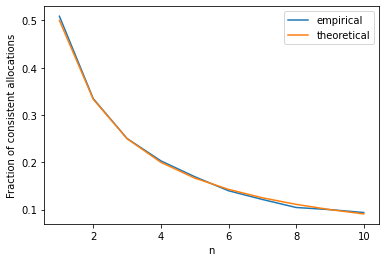

In [17]:
import matplotlib.pyplot as plt


pd.DataFrame(
    dict(
        n=n,
        empirical=same_allocation(n, n + 1),
        theoretical=1 / (n + 1),
    )
    for n in range(1, 10 + 1)
).set_index('n').plot()
_ = plt.ylabel('Fraction of consistent allocations')

### Implementation

In [20]:
from dataclasses import dataclass


ServerId = str


@dataclass(frozen=True)
class Server:
    server_id: ServerId
    seed: int = SEED
        
    @property
    @functools.lru_cache()
    def hash_value(self) -> int:
        return hash_mmh3(key=self.server_id, seed=self.seed)
        
    def __lt__(self, other: "Server") -> bool:
        return self.hash_value < other.hash_value

In [21]:
from typing import Set

In [23]:
class ConsistentHashing:
    def __init__(self, server_ids: Set[str], seed: int = SEED):
        assert len(server_ids) > 0
        self._seed = seed
        self._server_ids = server_ids
        self._server_allocations = None
        self._allocate_servers()
        
    def key_lookup(self, key: str) -> ServerId:
        """
        Allocate `key` to a server.
        """
        key_hash = hash_mmh3(key=key, seed=self._seed)
        # compute the distance between the hash value of
        # the input key and each server's hash
        distances = (
            (key_hash - server_obj.hash_value, server_id)
            for server_id, server_obj
            in self._server_allocations.items()
        )
        # find the server with the smallest positive distance
        # assign None if no such server exists
        # which means that the server with the largest hash is
        # responsible for this key
        closest = min((
            (dist, server_id)
            for dist, server_id in distances
            if dist >= 0
        ), default=None)
        return (
            # get the ID of the server with the largest hash value
            max(self._server_allocations.values()).server_id
            if closest is None
            else closest[1]
        )
        
    def add_server(self, server_id: ServerId) -> None:
        if server_id in self._server_allocations:
            raise ValueError(
                f"server_id={server_id} already exist."
            )
        self._server_ids.add(server_id)
        self._add_server(server_id=server_id)
    
    def remove_server(self, server_id: ServerId) -> None:
        if server_id not in self._server_allocations:
            raise ValueError(
                f"server_id={server_id} does not exist"
            )
        if len(self._server_allocations) == 1:
            raise ValueError(
                "only one server left- cannot delete"
            )
        self._server_ids.remove(server_id)
        self._remove_server(server_id=server_id)
        
    def _allocate_servers(self):
        """
        Map servers to the ring given the
        current set of server IDs.
        """
        self._server_allocations = {
            server_id: Server(
                server_id=server_id,
                seed=self._seed,
            )
            for server_id in self._server_ids
        }
        
    def _add_server(self, server_id: ServerId) -> None:
        self._server_allocations[server_id] = Server(
            server_id=server_id,
            seed=self._seed,
        )
        
    def _remove_server(self, server_id: ServerId) -> None:
        del self._server_allocations[server_id]

#### let's use it

In [32]:
ch = ConsistentHashing(server_ids={'1', '2', '3'})

In [33]:
url_ex1 = 'google.com'
url_ex2 = 'wikipedia.org'

In [34]:
assert ch.key_lookup(url_ex1) == '1'
assert ch.key_lookup(url_ex2) == '3'

In [35]:
ch.add_server('4')

In [36]:
assert ch.key_lookup(url_ex1) == '4'
assert ch.key_lookup(url_ex2) == '3'

In [37]:
ch.remove_server('4')

In [38]:
assert ch.key_lookup(url_ex1) == '1'
assert ch.key_lookup(url_ex2) == '3'